In [431]:
import pandas as pd 
import cv2 
import numpy as np 


In [432]:
def resize_img(im, new_shape=(640, 480), color=(0, 0, 0), auto=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im

In [433]:
def vis_pose(image, pose_result, threshold=0.3, node_label=None):
    if pose_result.shape[1] == 3: 

        keypoints = pose_result[:,:2]
        keypoints_score = pose_result[:,2]

        skeleton_edge = [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
                        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
                        [8, 10], [1, 2], [0, 1], [0, 2], [1,   3], [2, 4],
                        [3, 5], [4, 6]]
        for edge in skeleton_edge:
            start = keypoints[edge[0]]
            end = keypoints[edge[1]]
            if keypoints_score[edge[0]] < threshold or keypoints_score[edge[1]] < threshold:
                continue
            image = cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 255, 0), 2)

        for i in range(17):
            if keypoints_score[i] < threshold:
                continue
            (x, y) = keypoints[i]
            if node_label is None:
                color = (255, 255, 255)
            else:
                if node_label[i] == 0:
                    color = (255, 255, 255)
                elif node_label[i] == 1:
                    color = (0, 0, 255)
                elif node_label[i] == 2:
                    color = (255, 0, 0)

            image = cv2.circle(image, (int(x), int(y)), 8, color, -1)

        # image_vis = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 1)
        return image
    else: 
        keypoints = pose_result[:,:2]
        

        skeleton_edge =[[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
                        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
                        [8, 10], [1, 2], [0, 1], [0, 2], [1,   3], [2, 4],
                        [3, 5], [4, 6]]
        for edge in skeleton_edge:
            start = keypoints[edge[0]]
            end = keypoints[edge[1]]
            
            image = cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 0, 0), 2)

        for i in range(17):
            
            (x, y) = keypoints[i]
            if node_label is None:
                color = (2, 255, 23)
            else:
                if node_label[i] == 0:
                    color = (255, 255, 255)
                elif node_label[i] == 1:
                    color = (0, 0, 255)
                elif node_label[i] == 2:
                    color = (255, 0, 0)

            image = cv2.circle(image, (int(x), int(y)), 8, color, -1)

        # image_vis = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 1)
        return image

In [447]:
import matplotlib.pyplot as plt 
import open3d as o3d


skeleton_error  = pd.read_pickle('sample3.pkl')[0]
kp_error = skeleton_error['keypoints']
image_size = skeleton_error['image size']
label = skeleton_error['label']
skeleton_frame = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 0

frame_vis_error = vis_pose(skeleton_frame, kp_error)

frame_vis_error = resize_img(frame_vis_error)


In [449]:
skeleton_true  = pd.read_pickle('sample3.pkl')[2]
kp_true = skeleton_true['keypoints']
image_size = skeleton_true['image size']
label = skeleton_error['label']
skeleton_frame = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 0
frame_vis_true = vis_pose(skeleton_frame, kp_true)
frame_vis_true = resize_img(frame_vis_true)


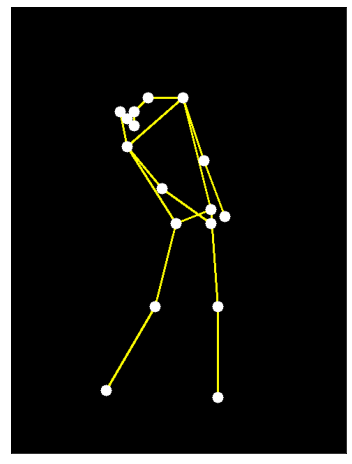

In [451]:

figure, axis = plt.subplots(1, 1)
figure.set_dpi=400
figure.set_size_inches(6, 10)

axis.imshow(frame_vis_true)
axis.set_xticks([])
axis.set_yticks([])
figure.savefig('skeleton2.png')
# axis[1].imshow(frame_vis_true)
# axis[1].set_xticks([])
# axis[1].set_yticks([])



In [452]:
import numpy as np
from scipy.optimize import minimize

class Transform:
    def __init__(self):
        self.scale_x = 1.0
        self.scale_y = 1.0
        self.theta = 0.0
        self.translate_x = 0.0
        self.translate_y = 0.0

    def rotate(self, theta):
        self.theta = theta

    def scale(self, scale_x, scale_y):
        self.scale_x = scale_x
        self.scale_y = scale_y

    def translate(self, translate_x, translate_y):
        self.translate_x = translate_x
        self.translate_y = translate_y

    def apply(self, points):
        theta_rad = np.radians(self.theta)
        rotation_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                                    [np.sin(theta_rad), np.cos(theta_rad)]])
        scaled_points = np.dot(points, np.diag([self.scale_x, self.scale_y]))
        translated_points = scaled_points + np.array([self.translate_x, self.translate_y])
        rotated_points = np.dot(translated_points, rotation_matrix)
        return rotated_points

    def error_function(self, params, points_A, points_B):
        scale_x, scale_y, theta, translate_x, translate_y = params
        self.scale(scale_x, scale_y)
        self.rotate(theta)
        self.translate(translate_x, translate_y)
        transformed_points = self.apply(points_A)
        error = 0
        for i in range(6, 17):  
            error += np.sum((transformed_points[i] - points_B[i]) ** 2)
        return error

    def find_parameters(self, points_A, points_B):
        initial_params = [self.scale_x, self.scale_y, self.theta, self.translate_x, self.translate_y]
        result = minimize(self.error_function, initial_params, args=(points_A, points_B))
        optimal_params = result.x
        self.scale_x, self.scale_y, self.theta, self.translate_x, self.translate_y = optimal_params


class AffineTransform:
    def __init__(self):
        self.a = 1.0
        self.b = 0.0
        self.c = 0.0
        self.d = 1.0
        self.tx = 0.0
        self.ty = 0.0

    def set_scale(self, scale_x, scale_y):
        self.a = scale_x
        self.d = scale_y

    def set_rotation(self, theta):
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        self.a = cos_theta
        self.b = -sin_theta
        self.c = sin_theta
        self.d = cos_theta

    def set_translation(self, translate_x, translate_y):
        self.tx = translate_x
        self.ty = translate_y

    def apply(self, points):
        transformation_matrix = np.array([[self.a, self.b, self.tx],
                                          [self.c, self.d, self.ty],
                                          [0, 0, 1]])
        homogeneous_points = np.column_stack((points, np.ones(len(points))))
        transformed_points = np.dot(homogeneous_points, transformation_matrix.T)
        return transformed_points[:, :2]  # Lấy các cột x, y

    def error_function(self, params, points_A, points_B):
        scale_x, scale_y, theta, translate_x, translate_y = params
        self.set_scale(scale_x, scale_y)
        self.set_rotation(theta)
        self.set_translation(translate_x, translate_y)
        transformed_points = self.apply(points_A)
        error += np.sum((transformed_points - points_B) ** 2)
        return error

    def find_parameters(self, points_A, points_B):
        initial_params = [self.a, self.d, 0.0, self.tx, self.ty]
        result = minimize(self.error_function, initial_params, args=(points_A, points_B))
        optimal_params = result.x
        self.a, self.d, _, self.tx, self.ty = optimal_params

transform = Transform()
transform.find_parameters(kp_error[:,:2], kp_true[:,:2])

points_transformed = transform.apply(kp_error[:,:2])

print("Tập điểm A:")
print(kp_error[:,:2])

print("\nTập điểm B:")
print(kp_true[:,:2])

print("\nTập điểm A sau khi biến đổi:")
print(points_transformed)


Tập điểm A:
[[207.6015625 171.       ]
 [215.0390625 163.5625   ]
 [200.1640625 163.5625   ]
 [222.4765625 156.125    ]
 [192.7265625 163.5625   ]
 [244.7890625 163.5625   ]
 [185.2890625 193.3125   ]
 [281.9765625 200.75     ]
 [215.0390625 245.375    ]
 [274.5390625 252.8125   ]
 [244.7890625 275.125    ]
 [267.1015625 275.125    ]
 [229.9140625 275.125    ]
 [274.5390625 334.625    ]
 [215.0390625 349.5      ]
 [259.6640625 423.875    ]
 [170.4140625 423.875    ]]

Tập điểm B:
[[176.5625  171.46875]
 [176.5625  151.53125]
 [166.59375 161.5    ]
 [196.5     131.59375]
 [156.625   151.53125]
 [246.34375 131.59375]
 [166.59375 201.375  ]
 [276.25    221.3125 ]
 [216.4375  261.1875 ]
 [306.15625 301.0625 ]
 [286.21875 311.03125]
 [286.21875 291.09375]
 [236.375   311.03125]
 [296.1875  430.65625]
 [206.46875 430.65625]
 [296.1875  560.25   ]
 [136.6875  550.28125]]

Tập điểm A sau khi biến đổi:
[[198.75990717 159.43609179]
 [209.53154315 147.73593254]
 [187.65029175 148.05635921]
 [220.

In [453]:
skeleton_frame = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 0
# skeleton_frame = resize_img(skeleton_frame)
frame_vis = vis_pose(skeleton_frame, points_transformed)
frame_vis = vis_pose(skeleton_frame, kp_true)
frame_vis = resize_img(frame_vis)

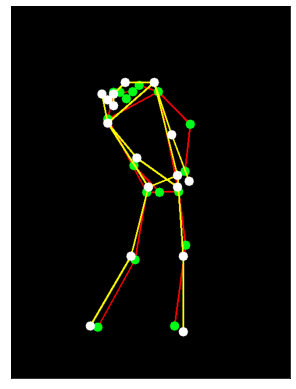

In [455]:
figure, axis = plt.subplots(1, 1)
figure.set_dpi=400
figure.set_size_inches(5, 10)
axis.imshow(frame_vis)
axis.set_xticks([])
axis.set_yticks([])
figure.savefig('res.png')

In [355]:
class PoseComparison:
    def __init__(self, skeleton1, skeleton2):
        self.skeleton1 = skeleton1
        self.skeleton2 = skeleton2
        self.connections = [[6,8,10], [5, 7, 9], [8,6,12], [11,5,7], [6,12,14], [5,11,13],[12, 14,16], [11,13,15]]

    def compute_angles(self, skeleton):
        angles = []
        for connection in self.connections:
            point1 = skeleton[connection[0]-5]
            point2 = skeleton[connection[1]-5]
            point3 = skeleton[connection[2]-5]

            vector1 = point1 - point2
            vector2 = point3 - point2

            dot_product = np.dot(vector1, vector2)
            norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)

            angle = np.arccos(dot_product / norm_product)*180/np.pi
            angles.append(angle)

        return angles

    def compare_poses(self, threshold=0.1):
        angles1 = self.compute_angles(self.skeleton1)
        angles2 = self.compute_angles(self.skeleton2)

        different_angles = []
        for i, angle1 in enumerate(angles1):
            angle2 = angles2[i]
            diff = np.abs(angle1 - angle2)
            if diff > threshold:
                different_angles.append((self.connections[i], diff))

        return different_angles


In [356]:
compare = PoseComparison(points_transformed, kp_true)


In [357]:
different_angles = compare.compare_poses(threshold=15)

In [360]:
different_angles

[([6, 8, 10], 27.94883398311285),
 ([8, 6, 12], 23.623740087628853),
 ([11, 5, 7], 108.77845217510134),
 ([6, 12, 14], 20.71443887623306),
 ([5, 11, 13], 45.55204744169046),
 ([12, 14, 16], 128.39188729435656),
 ([11, 13, 15], 16.12538651007671)]

In [359]:
points_transformed.shape

(17, 2)

In [344]:
(points_transformed[0] - kp_true[:,:2][0])**2

array([65.21858843, 65.88510705])